In [40]:
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import re
import string
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import warnings
import nltk
from nltk.corpus import stopwords
from utils import *
from transformers import BertTokenizer

In [41]:
# Suppress warnings from being displayed
warnings.filterwarnings('ignore')

In [42]:
# Download the NLTK stopwords dataset
nltk.download('stopwords')

# Create a set of English stopwords using NLTK
stopWords_nltk = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/dario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
# Create an instance of the CleanText class
clean = CleanText()

# Load the dataset from a CSV file into a pandas DataFrame
df = pd.read_csv("dataset.csv")

In [44]:
# show column names
print("df.columns: ", df.columns) 

df.columns:  Index(['address', 'categories', 'city', 'country', 'name', 'province',
       'reviews.rating', 'reviews.text'],
      dtype='object')


In [45]:
# head of df
df.head()

,address,categories,city,country,name,province,reviews.rating,reviews.text
0,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,4.0,Pleasant 10 min walk along the sea front to th...
1,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,5.0,Really lovely hotel. Stayed on the very top fl...
2,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,5.0,Ett mycket bra hotell. Det som drog ner betyge...
3,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,5.0,We stayed here for four nights in October. The...
4,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,5.0,We stayed here for four nights in October. The...


In [46]:
# count of ratings
# Create a histogram to visualize the distribution of review ratings in the dataset
fig = px.histogram(df,          # Data source: the DataFrame containing the dataset
             x = 'reviews.rating',          # Column to be plotted on the x-axis: review ratings
             title = 'Histogram of Review Rating',          # Title of the histogram
             template = 'ggplot2',          # Visual template for the plot (style similar to ggplot2)
             color = 'reviews.rating',          # Use the 'reviews.rating' column to color the bars
             color_discrete_sequence= px.colors.sequential.Blues_r,         # Set color sequence to a reverse sequential blue palette
             opacity = 0.8,         # Set the opacity of the bars to 80%
             height = 525,          # Set the height of the figure to 525 pixels
             width = 835,           # Set the width of the figure to 835 pixels
            )

# Update the y-axis label to 'Count' to reflect the number of occurrences
fig.update_yaxes(title='Count')

# Display the histogram
fig.show()

In [47]:
# Display basic information about the DataFrame, including the number of entries, column names, 
# non-null counts, and data types for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45912 entries, 0 to 45911
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   address         45912 non-null  object 
 1   categories      45912 non-null  object 
 2   city            45912 non-null  object 
 3   country         45912 non-null  object 
 4   name            45912 non-null  object 
 5   province        45912 non-null  object 
 6   reviews.rating  45050 non-null  float64
 7   reviews.text    45887 non-null  object 
dtypes: float64(1), object(7)
memory usage: 2.8+ MB


In [48]:
# Encode the review ratings into numerical labels using a custom encoding function
# Apply the `label_encode` function to each value in the 'reviews.rating' column
# and store the result in a new column 'label'
df["label"] = df["reviews.rating"].apply(lambda x: label_encode(x))


# Map the numerical labels to their corresponding names using a custom mapping function
# Apply the `label2name` function to each value in the 'label' column
# and store the result in a new column 'label_name'
df["label_name"] = df["label"].apply(lambda x: label2name(x))

In [49]:
# Clean the text in the 'reviews.text' column by applying several transformations

# 1. Convert all text to lowercase:
#    - Apply a lambda function that checks if the value is a string.
#    - If it's a string, convert it to lowercase; otherwise, convert the value to a string as it is.
df["reviews.text"] = df["reviews.text"].apply(lambda x: str(x).lower() if isinstance(x, str) else str(x))


# 2. Further clean the text by:
#    - Removing emojis using the `remove_emoji` function.
#    - Cleaning the text using the `clean` function (which might handle additional tasks such as trimming whitespace).
#    - Removing punctuation marks with the `remove_punct` function.
#    - Removing numbers using the `remove_numbers` function.
#    The result of these transformations is stored back in the 'reviews.text' column.
df["reviews.text"] = df["reviews.text"].apply(lambda x: remove_numbers(remove_punct(clean(remove_emoji(x))[0][0])))

In [50]:
# head of df
df.head()

,address,categories,city,country,name,province,reviews.rating,reviews.text,label,label_name
0,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,4.0,pleasant min walk along the sea front to the ...,2.0,Positive
1,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,5.0,really lovely hotel stayed on the very top fl...,2.0,Positive
2,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,5.0,ett mycket bra hotell det som drog ner betyge...,2.0,Positive
3,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,5.0,we stayed here for four nights in october the...,2.0,Positive
4,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,5.0,we stayed here for four nights in october the...,2.0,Positive


In [51]:
# This figure visualizes the distribution of labels in the dataset.
# The pie chart on the left shows the percentage of each label, while the bar chart on the right shows the count of each label.

# Create a figure with a pie chart and a bar chart side by side
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])

# Define colors for the charts
colors = ['gold', 'mediumturquoise', 'lightgreen'] # darkorange

# Add a pie chart showing the distribution of labels
fig.add_trace(go.Pie(labels=df.label_name.value_counts().index,
                             values=df.label.value_counts().values), 1, 1)

# Customize the pie chart: show label and percentage on hover, set font size, and add segment borders
fig.update_traces(hoverinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

# Add a bar chart showing label counts, using the same colors
fig.add_trace(go.Bar(x=df.label_name.value_counts().index, y=df.label.value_counts().values, marker_color = colors), 1,2)

# Display the figure
fig.show()

In [52]:
# tokenize data
df["tokenized_review"] = df["reviews.text"].apply(lambda x: tokenize(x))

# calculate token count for any sent
df["sent_token_length"] = df["tokenized_review"].apply(lambda x: len(x.split()))

In [53]:
# This code creates a histogram to visualize the distribution of sentence token lengths in the dataset.
# It plots the length of sentences (in tokens) on the x-axis and the percentage of occurrences on the y-axis.
# The histogram has 20 bins, grouping the data into intervals, and it uses a color scheme from the 'algae' palette.
# The 'histnorm' parameter is set to "percent", so the y-axis represents the percentage of the total data in each bin.

fig = px.histogram(df, x="sent_token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")

# Display the histogram
fig.show()

In [54]:
# This code calculates the proportion (mean) of rows in the DataFrame where the 'sent_token_length' column is less than 512.
# It returns the percentage of sentences that have fewer than 512 tokens.

(df.sent_token_length < 512).mean()

0.9995426032409828

In [55]:
# This code initializes a BERT tokenizer using the pre-trained 'bert-base-uncased' model.
# The 'uncased' version of BERT means that it treats uppercase and lowercase letters as the same (case-insensitive).
# The 'do_lower_case=True' parameter further ensures that all input text is converted to lowercase before tokenization.

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [56]:
# Tokenize the text data using the BERT tokenizer and compute the length of the tokenized sentences.
# The 'tokenizer' object processes each review in the 'reviews.text' column:
# - 'add_special_tokens=False' indicates that no special tokens (e.g., [CLS], [SEP]) are added to the text.
# - '["input_ids"]' extracts the token IDs from the tokenized output.
# Calculate the length of the token IDs list for each review and store this length in a new column 'sent_bert_token_length'.

df["sent_bert_token_length"] = df["reviews.text"].apply(lambda x: len(tokenizer(x, add_special_tokens=False)["input_ids"]))

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


In [57]:
# Create a histogram to visualize the distribution of BERT token lengths in the dataset.
# The x-axis represents the length of sentences in tokens (as calculated by the BERT tokenizer),
# and the y-axis shows the percentage of occurrences in each bin.
# The histogram is divided into 20 bins, and it uses the 'algae' color palette for the bars.
# The 'barmode' is set to 'group' to group bars for comparison, and 'histnorm="percent"' normalizes the histogram to show percentages.

fig = px.histogram(df, x="sent_bert_token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")

# Display the histogram
fig.show()

In [58]:
# Calculate the proportion of data where the BERT token length is less than 512 tokens.
# This code checks each value in the 'sent_bert_token_length' column to see if it is less than 512,
# and then computes the mean of these boolean values. The result represents the percentage of sentences
# that have fewer than 512 tokens.

(df.sent_bert_token_length < 512).mean()

0.9994990416448859

In [59]:
# Calculate the number of characters in each review and store it in a new column 'char_count'.
df['char_count'] = df['reviews.text'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Create a figure with a specific size and layout
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))

    # Define a grid layout with 3 columns and 3 rows for subplots
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Add a subplot to the figure that spans the first two columns of the first row
    ax1 = fig.add_subplot(grid[0, :2])

    # Set the title for this subplot to 'Histogram'
    ax1.set_title('Histogram')

    # Plot the distribution of the specified feature using seaborn's distplot
    # This includes both a histogram (bars) and a Kernel Density Estimate (KDE) curve
    sns.distplot(df.loc[:, feature],
                 hist=True,         # Show histogram bars
                 kde=True,          # Show KDE curve
                 ax=ax1,            # Specify subplot for the plot
                 )
    
    # Set the y-axis label to 'Frequency'
    ax1.set(ylabel='Frequency')

    # Set the number of bins on the x-axis to 20
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Set the main title for the entire figure
    plt.suptitle(f'{title}', fontsize=24)

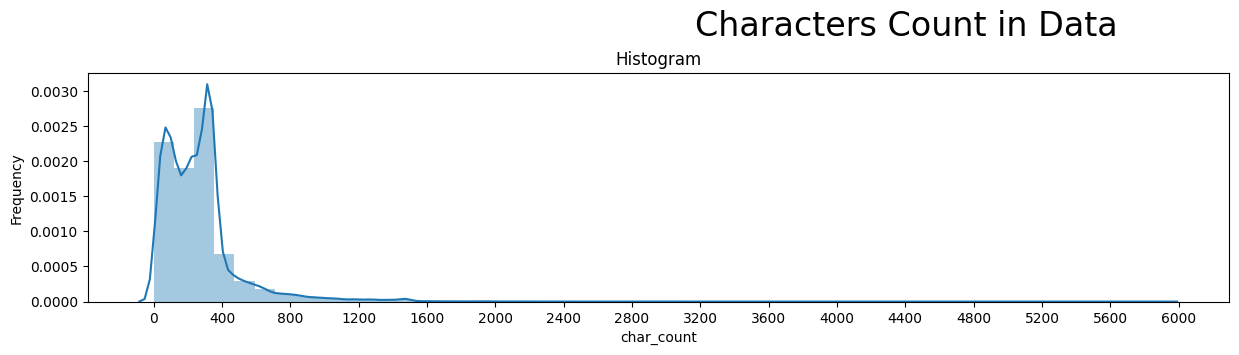

In [60]:
# Call the plot_dist3 function to visualize the distribution of character counts in the 'char_count' column of the DataFrame.
# The histogram will display the frequency of different character counts across reviews, with a Kernel Density Estimate (KDE) curve overlaid.
# The title of the plot will be 'Characters Count in Data'.

plot_dist3(df, 'char_count','Characters Count in Data')

In [61]:
# Creating a new feature for the visualization.
df['Character Count'] = df['reviews.text'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Create a figure with customized size and layout
    fig = plt.figure(constrained_layout=True, figsize=(24, 12))
    
    # Define a 3x3 grid for placing subplots within the figure
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Add a subplot for the histogram, spanning the first two columns of the first row
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title of the histogram subplot
    ax1.set_title('Histogram')
    # Plot a histogram with a Kernel Density Estimate (KDE) curve for the specified feature
    sns.distplot(df.loc[:, feature],
                 hist=True,             # Show histogram bars
                 kde=True,              # Include KDE curve
                 ax=ax1,                # Use the specified subplot
                 color='#e74c3c')       # Set the color of the bars and KDE curve
    ax1.set(ylabel='Frequency')  # Set the y-axis label to 'Frequency'
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))  # Set the number of x-axis bins to 20

    # Add a subplot for the Empirical Cumulative Distribution Function (ECDF) plot, spanning the first two columns of the second row
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title of the ECDF subplot
    ax2.set_title('Empirical CDF')
    # Plot an ECDF with KDE and histogram, showing cumulative probability
    sns.distplot(df.loc[:, feature],
                 ax=ax2,               # Use the specified subplot
                 kde_kws={'cumulative': True},  # Configure KDE for cumulative distribution
                 hist_kws={'cumulative': True}, # Configure histogram for cumulative distribution
                 color='#e74c3c')      # Set the color of the ECDF plot
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))  # Set the number of x-axis bins to 20
    ax2.set(ylabel='Cumulative Probability')  # Set the y-axis label to 'Cumulative Probability'

    # Set the main title for the entire figure
    plt.suptitle(f'{title}', fontsize=24)

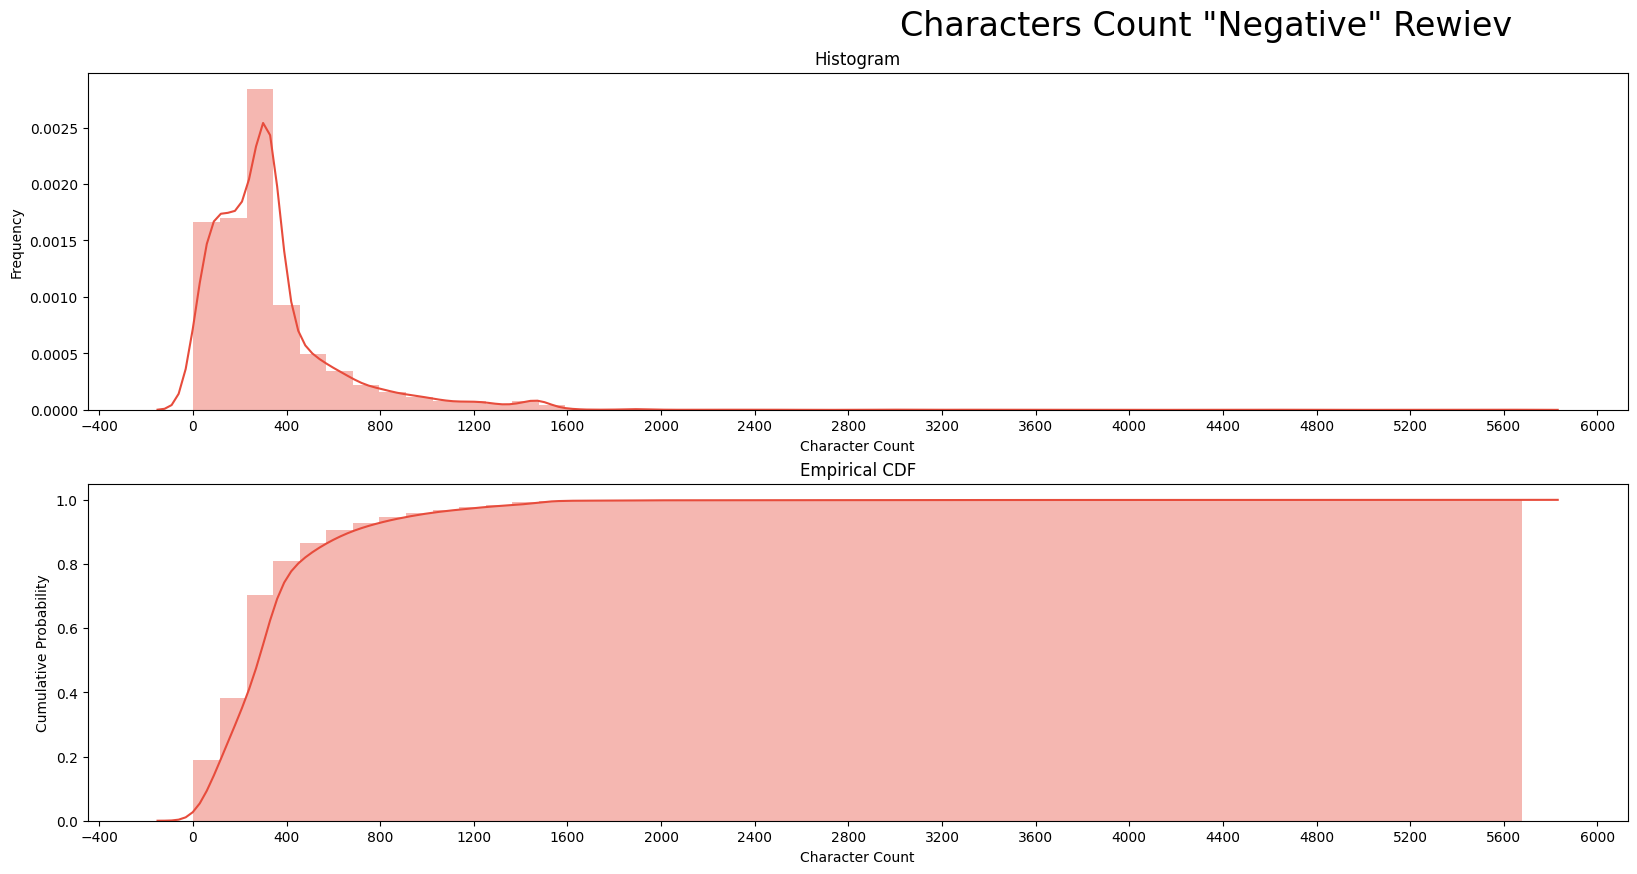

In [62]:
# Call the plot_dist3 function to visualize the distribution of character counts for reviews labeled as '0' (e.g., negative reviews).
# The histogram will show the frequency of different character counts in these reviews, with a Kernel Density Estimate (KDE) curve overlaid.
# The Empirical Cumulative Distribution Function (ECDF) plot will display the cumulative probability of character counts for the same subset.
# The title of the plot will be 'Characters Count "Negative" Review', indicating that the data represents negative reviews.

plot_dist3(df[df['label'] == 0], 'Character Count','Characters Count "Negative" Rewiev')

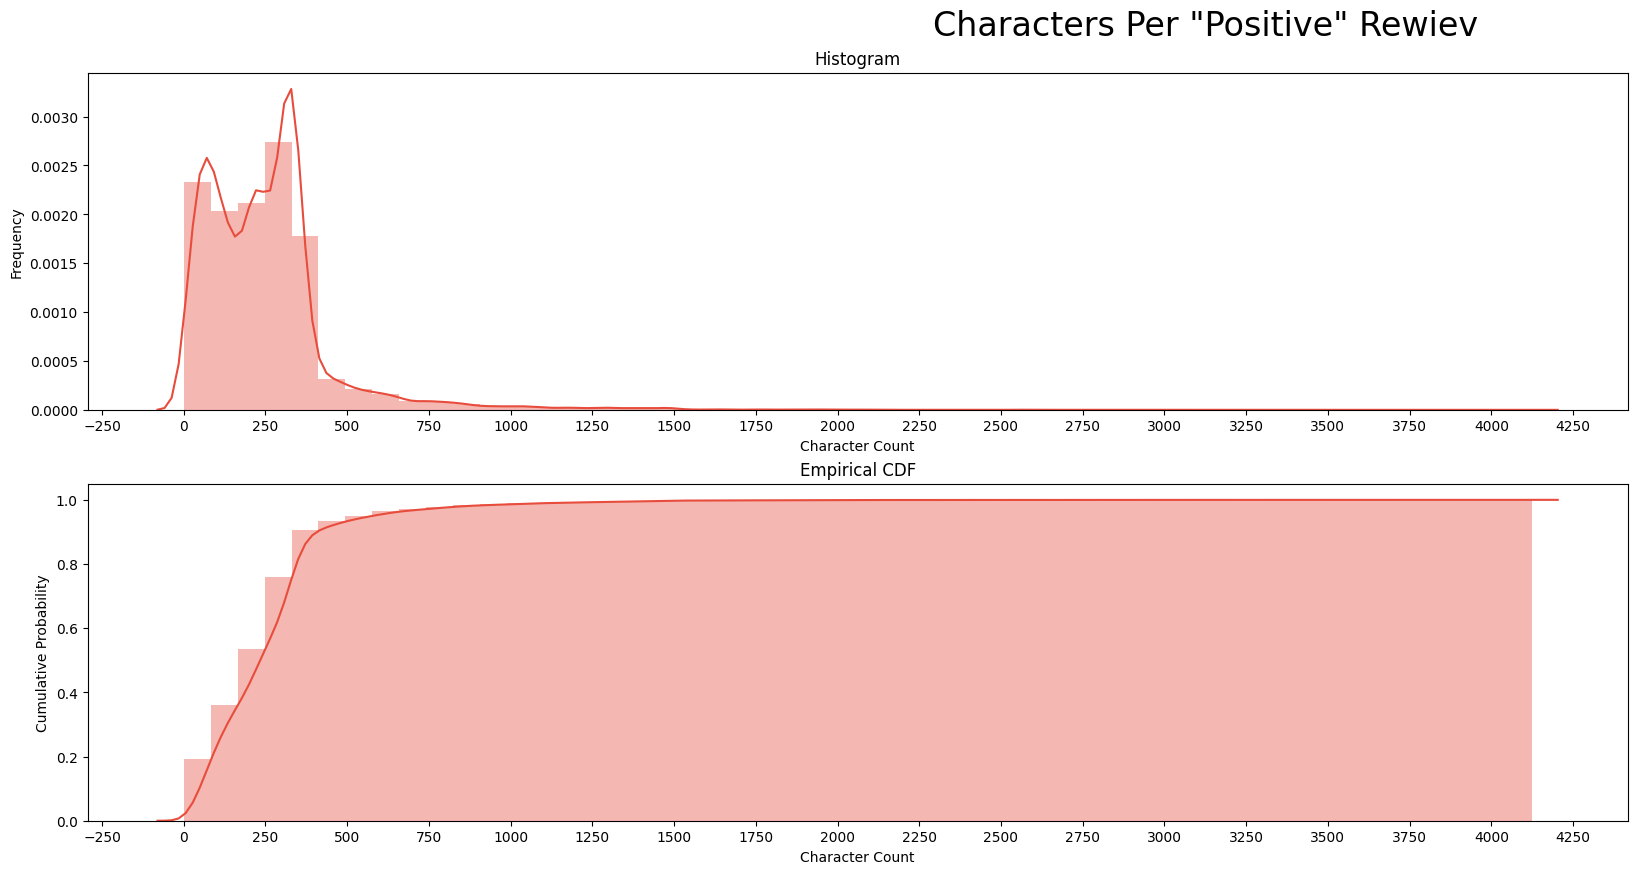

In [63]:
# Call the plot_dist3 function to visualize the distribution of character counts for reviews labeled as '2' (e.g., positive reviews).
# The histogram will show the frequency of different character counts in these reviews, with a Kernel Density Estimate (KDE) curve overlaid.
# The Empirical Cumulative Distribution Function (ECDF) plot will display the cumulative probability of character counts for the same subset.
# The title of the plot will be 'Characters Count "Positive" Review', indicating that the data represents positive reviews.

plot_dist3(df[df['label'] == 2], 'Character Count','Characters Per "Positive" Rewiev')

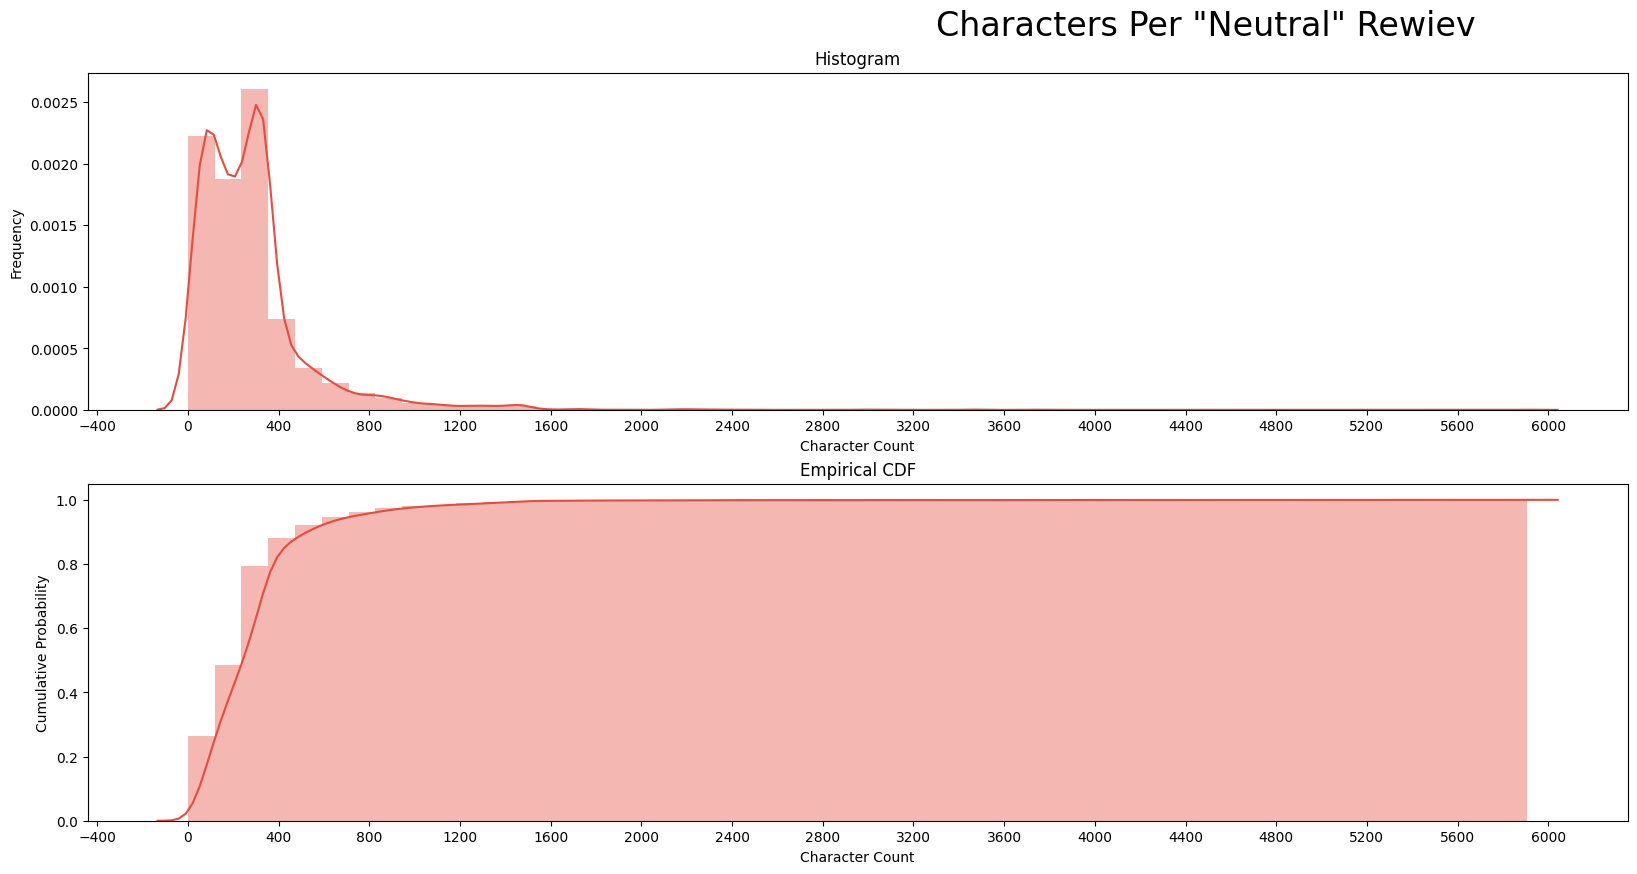

In [64]:
# Call the plot_dist3 function to visualize the distribution of character counts for reviews labeled as '1' (e.g., neutral reviews).
# The histogram will show the frequency of different character counts in these reviews, with a Kernel Density Estimate (KDE) curve overlaid.
# The Empirical Cumulative Distribution Function (ECDF) plot will display the cumulative probability of character counts for the same subset.
# The title of the plot will be 'Characters Count "Neutral" Review', indicating that the data represents neutral reviews.

plot_dist3(df[df['label'] == 1], 'Character Count','Characters Per "Neutral" Rewiev')

In [65]:
def plot_word_number_histogram(textno, textye, textz):
    """A function for comparing word counts across different review categories"""

    # Create a figure with three vertically stacked subplots, sharing the y-axis
    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(18, 12), sharey=True)
    
    # Plot histograms of word counts for each review category
    # 'textno' for negative reviews
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    # 'textye' for neutral reviews
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    # 'textz' for positive reviews
    sns.distplot(textz.str.split().map(lambda x: len(x)), ax=axes[2], color='#e74c3c')

    # Customize the x and y labels and titles for each subplot
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Negative')  # Title for negative review histogram
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Neutral')   # Title for neutral review histogram
    axes[2].set_xlabel('Word Count')
    axes[2].set_title('Positive')  # Title for positive review histogram
    
    # Set the main title for the entire figure
    fig.suptitle('Words Per Review', fontsize=24, va='baseline')
    
    # Adjust the layout to ensure the title and subplots fit well within the figure
    fig.tight_layout()

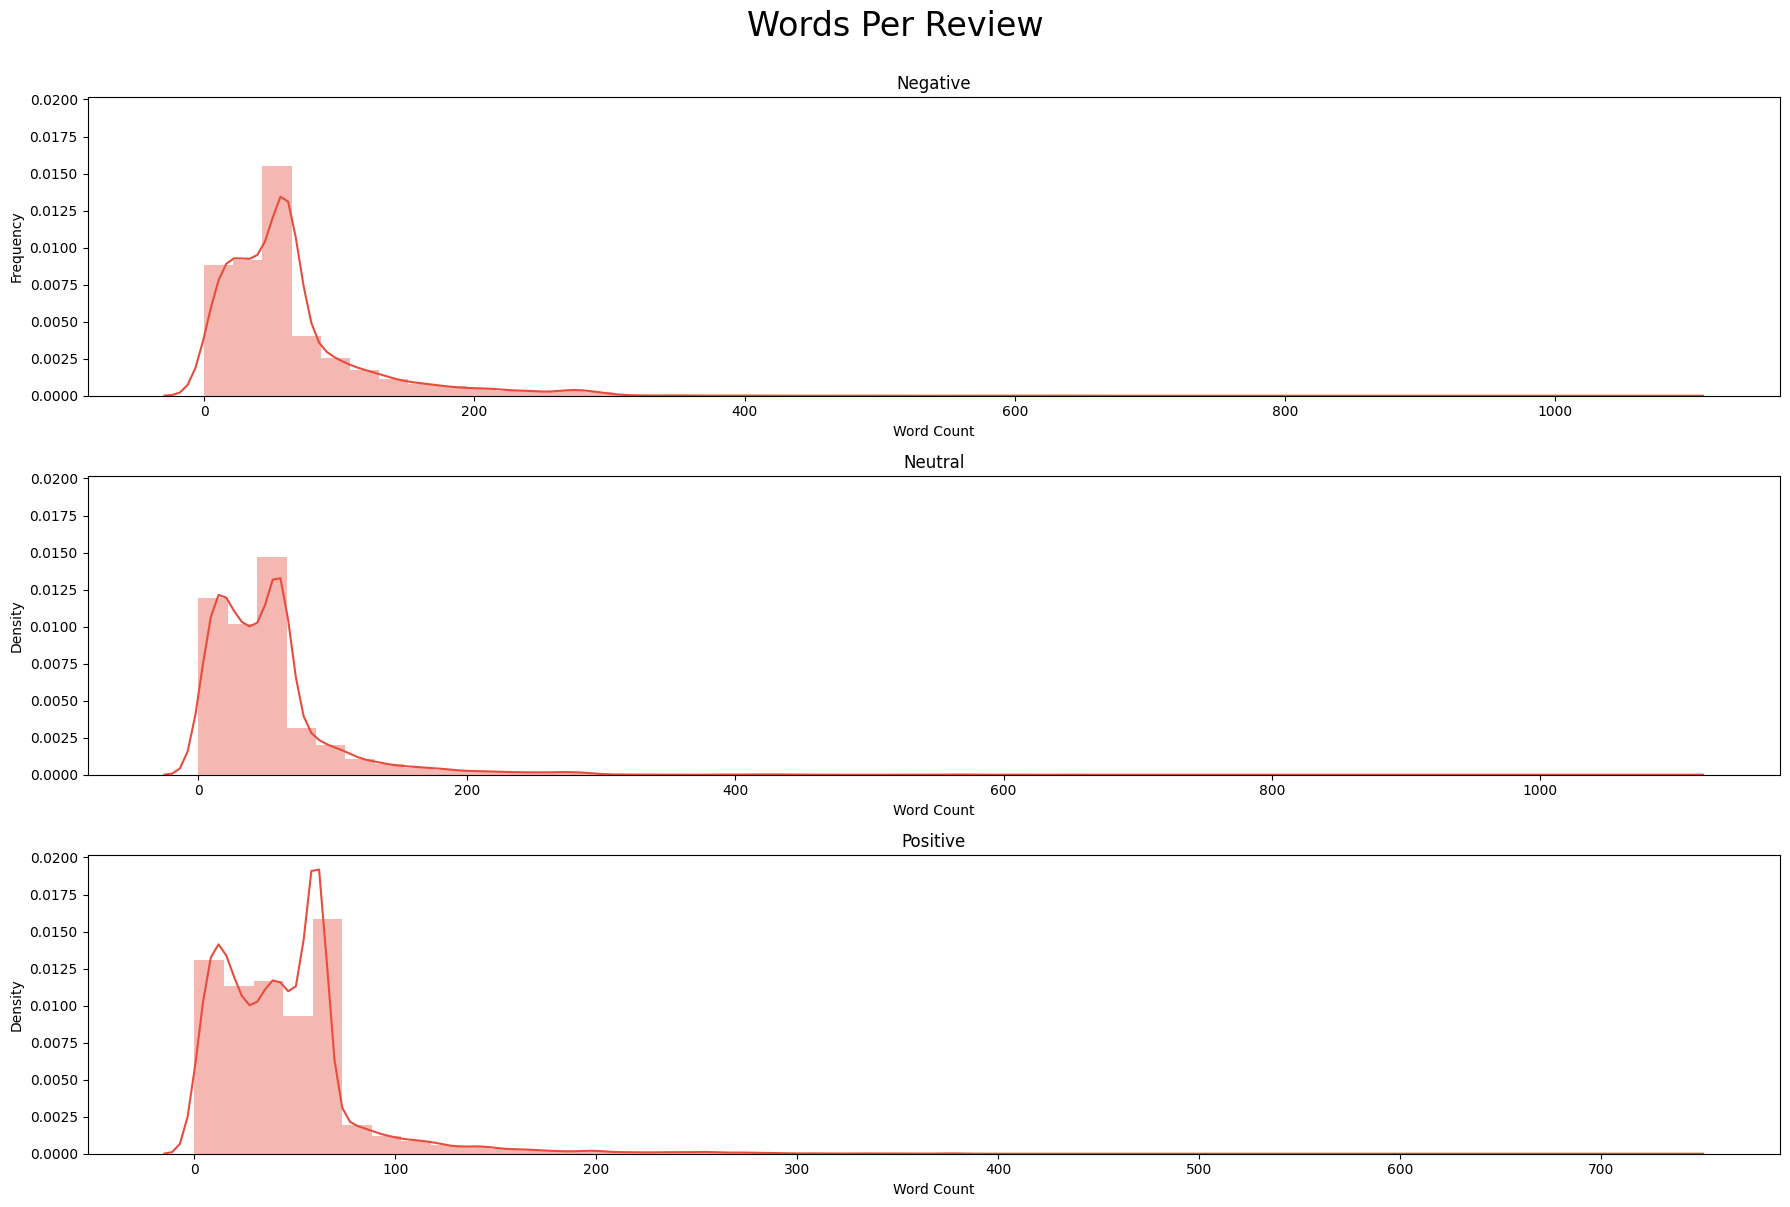

In [66]:
# Call the plot_word_number_histogram function to visualize the distribution of word counts for reviews categorized by label.
# - 'textno' corresponds to reviews with a label of 0 (negative reviews).
# - 'textye' corresponds to reviews with a label of 1 (neutral reviews).
# - 'textz' corresponds to reviews with a label of 2 (positive reviews).
# The function will generate three histograms:
# 1. A histogram showing the word count distribution for negative reviews.
# 2. A histogram showing the word count distribution for neutral reviews.
# 3. A histogram showing the word count distribution for positive reviews.
# Each histogram will have its own subplot with labels and titles for easy comparison.

plot_word_number_histogram(df[df['label'] == 0]['reviews.text'],
                           df[df['label'] == 1]['reviews.text'],
                           df[df['label'] == 2]['reviews.text'],
                          )

In [67]:
# This code removes punctuation from the tokenized reviews.
# The 'tokenized_review' column contains tokenized text, where each review is represented as a list of words.
# The lambda function applies the 'remove_punct' function to each list in the 'tokenized_review' column,
# which removes any punctuation from the words.

df['tokenized_review'] = df['tokenized_review'].apply(lambda x: remove_punct(x))

In [68]:
# This code visualizes the most common words in the tokenized reviews from a DataFrame

# Extract tokenized reviews from the DataFrame
texts = df['tokenized_review']
# Split each review into a list of words and convert the lists into a single list of words
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
# Count the frequency of each word in the corpus
counter = Counter(corpus)
# Get the most common words and their counts
most = counter.most_common()

# Initialize lists for storing words and their frequencies
x, y = [], []
# Iterate through the top 30 most common words
for word, count in most[:30]:
    # Exclude stopwords from the plot
    if word not in stopWords_nltk:
        x.append(word)  # Add word to the list of words
        y.append(count) # Add corresponding count to the list of counts

# Create a horizontal bar chart to display the most common words
fig = go.Figure(go.Bar(
            x=y,               # Frequencies on the x-axis
            y=x,               # Words on the y-axis
            orientation='h',  # Horizontal bars
            marker=dict(
                color='rgba(50, 171, 96, 0.6)',  # Bar color
                line=dict(
                    color='rgba(50, 171, 96, 1.0)',  # Bar border color
                    width=1  # Bar border width
                ),
            ),
            name='Most Common Word',  # Legend label
        ))

# Customize the layout of the figure
fig.update_layout(
    title={
        'text': "Most Common Words",  # Title of the plot
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    font=dict(
        family="Courier New, monospace",  # Font style
        size=18,  # Font size
        color="RebeccaPurple"  # Font color
    )
)

# Display the figure
fig.show()

In [69]:
# This code generates a subplot with three horizontal bar charts, each representing the most common words for different sentiment labels

# Create a subplot layout with 1 row and 3 columns
fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]

# Iterate over the three sentiment labels
for i in range(3):
    # Filter tokenized reviews by sentiment label
    texts = df[df["label"] == i]['tokenized_review']

    # Split each review into individual words and create a list of all words
    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for sublist in new for word in sublist]
    
    # Count the frequency of each word
    counter = Counter(corpus)
    # Get the 30 most common words
    most = counter.most_common()
    x, y = [], []

    # Filter out stopwords and prepare data for plotting
    for word, count in most[:30]:
        if word not in stopWords_nltk:
            x.append(word)  # Words
            y.append(count) # Frequencies

    # Add a horizontal bar chart for the current sentiment label
    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h',
                type="bar",
                name=title_[i],  # Label for the legend
                marker=dict(color=colors[i])), 1, i+1)

# Customize the layout of the figure
fig.update_layout(
    autosize=False,
    width=2000,
    height=600,
    title=dict(
        text='<b>Most Common Unigrams per Sentiment Classes</b>',  # Main title
        x=0.5,
        y=0.95,
        font=dict(
            family="Courier New, monospace",  # Font style
            size=24,  # Font size
            color="RebeccaPurple"  # Font color
        )
    ),
)

# Display the figure
fig.show()

In [70]:
def _get_top_ngram(corpus, n=None):
    # This function extracts the top n-grams from the provided corpus.
    # 'corpus' is a list of text documents, and 'n' specifies the n-gram range (e.g., 1 for unigrams, 2 for bigrams).

    # Create a CountVectorizer instance for extracting n-grams with a specified range
    vec = CountVectorizer(ngram_range=(n, n),
                          max_df=0.9  # Ignore terms that appear in more than 90% of the documents
                          ).fit(corpus)
    
    # Transform the corpus into a bag-of-words matrix
    bag_of_words = vec.transform(corpus)
    
    # Sum the occurrences of each n-gram across all documents
    sum_words = bag_of_words.sum(axis=0)
    
    # Create a list of (n-gram, frequency) tuples
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    
    # Sort the list of n-grams by frequency in descending order
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    # Return the top 15 n-grams by frequency
    return words_freq[:15]

In [71]:
# Create a subplot layout with 1 row and 3 columns
fig = make_subplots(rows=1, cols=3)

# Define titles for each subplot based on sentiment labels
title_ = ["negative", "neutral", "positive"]

# Iterate over the three sentiment labels
for i in range(3):
    # Filter tokenized reviews by sentiment label
    texts = df[df["label"] == i]['tokenized_review']

    # Flatten the list of tokenized reviews into a single list of words
    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for sublist in new for word in sublist]
    
    # Get the top 15 bigrams for the current sentiment label
    top_n_bigrams = _get_top_ngram(texts, 2)[:15]
    x, y = map(list, zip(*top_n_bigrams))  # Separate bigrams and their frequencies

    # Add a horizontal bar chart for the current sentiment label
    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h',
                type="bar",
                name=title_[i],  # Label for the legend
                marker=dict(color=colors[i])), 1, i+1)
    
# Customize the layout of the figure
fig.update_layout(
    autosize=False,
    width=2000,
    height=600,
    title=dict(
        text='<b>Most Common Bigrams per Sentiment Classes</b>',  # Main title
        x=0.5,
        y=0.95,
        font=dict(
            family="Courier New, monospace",  # Font style
            size=24,  # Font size
            color="RebeccaPurple"  # Font color
        )
    )
)

# Display the figure
fig.show()

In [72]:
# Create a subplot layout with 1 row and 3 columns
fig = make_subplots(rows=1, cols=3)

# Define titles for each subplot based on sentiment labels
title_ = ["negative", "neutral", "positive"]

# Iterate over the three sentiment labels
for i in range(3):
    # Filter tokenized reviews by sentiment label
    texts = df[df["label"] == i]['tokenized_review']

    # Flatten the list of tokenized reviews into a single list of words
    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for sublist in new for word in sublist]
    
    # Get the top 15 trigrams (three-word phrases) for the current sentiment label
    top_n_trigrams = _get_top_ngram(texts, 3)[:15]
    x, y = map(list, zip(*top_n_trigrams))  # Separate trigrams and their frequencies

    # Add a horizontal bar chart for the current sentiment label
    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h',
                type="bar",
                name=title_[i],  # Label for the legend
                marker=dict(color=colors[i])), 1, i+1)
    
# Customize the layout of the figure
fig.update_layout(
    autosize=False,
    width=2000,
    height=600,
    title=dict(
        text='<b>Most Common Trigrams per Sentiment Classes</b>',  # Main title
        x=0.5,
        y=0.95,
        font=dict(
            family="Courier New, monospace",  # Font style
            size=24,  # Font size
            color="RebeccaPurple"  # Font color
        )
    )
)

# Display the figure
fig.show()

In [73]:
df = df.dropna()

In [74]:
# Save the DataFrame to a CSV file named "training_dataset.csv"
# The index column is not included in the output file

df.to_csv("training_dataset.csv", index=False)